In [1]:
from __future__ import print_function,division
import numpy as np
import nltk
import json
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply,LeakyReLU
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam,sgd
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
from keras.layers import Embedding
import tensorflow as tf
import cPickle as pickle
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
import gensim
from nmt_utils import *
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from gensim.models import KeyedVectors
import cPickle as pickle
import psutil

Using TensorFlow backend.


In [2]:
psutil.virtual_memory()

svmem(total=8240300032, available=6411116544, percent=22.2, used=1414701056, free=5703749632, active=1588920320, inactive=723636224, buffers=95129600, cached=1026719744, shared=154492928)

In [3]:
#FN1='embeddingReviewsFilewithOtherdata'
FN2='myPaddedDataFile'

In [4]:
with open('%s.pkl'%FN2,'rb') as fp:
    embeddingReviews, modiefiedSummaryWord_index,myPaddedData= pickle.load(fp)

In [5]:
psutil.virtual_memory()

svmem(total=8240300032, available=6399401984, percent=22.3, used=1421742080, free=5644189696, active=1596702720, inactive=774131712, buffers=119242752, cached=1055125504, shared=158695424)

In [6]:
paddedReviews=myPaddedData['paddedReviews']
paddedSummary=myPaddedData['paddedSummary']
paddedModifiedSummary=myPaddedData['paddedModifiedSummary']
testPaddedReviews=myPaddedData['testPaddedReviews']
testPaddedSummary=myPaddedData['testPaddedSummary']
#testEncoded_modiefiedSummaries=myData['testEncoded_modiefiedSummaries']
#valPaddedReviews=myPaddedData['valPaddedReviews']
#valPaddedSummary=myPaddedData['valPaddedSummary']

In [7]:
TrainingDataIX=paddedReviews
TrainingDataTY=paddedSummary
TrainingDataIY=paddedModifiedSummary
TrainingDataIX.shape,TrainingDataIY.shape,TrainingDataTY.shape

((950, 200), (950, 40), (950, 40))

In [8]:
TestDataIX=testPaddedReviews
TestDataTY=testPaddedSummary

In [9]:
#ValDataIX=valPaddedReviews
#ValDataTY=valPaddedSummary

In [10]:
psutil.virtual_memory()

svmem(total=8240300032, available=6394519552, percent=22.4, used=1426477056, free=5638500352, active=1601617920, inactive=774909952, buffers=119345152, cached=1055977472, shared=158695424)

In [11]:
nb_samples=len(TrainingDataIX)
nb_samples

950

In [12]:
ModifiedVocabSize=len(modiefiedSummaryWord_index)


In [13]:
ModifiedVocabSize

5425

In [14]:
psutil.virtual_memory()

svmem(total=8240300032, available=6396149760, percent=22.4, used=1425022976, free=5639954432, active=1600008192, inactive=775438336, buffers=119443456, cached=1055879168, shared=158695424)

In [15]:
decoderInputSummary=to_categorical(paddedModifiedSummary,num_classes=ModifiedVocabSize)

In [16]:
decoderInputSummary=decoderInputSummary.reshape(nb_samples,-1,ModifiedVocabSize)

In [17]:
decoderInputSummary.shape

(950, 40, 5425)

In [18]:
psutil.virtual_memory()

svmem(total=8240300032, available=4770807808, percent=42.1, used=3050909696, free=4014518272, active=3221848064, inactive=775122944, buffers=119549952, cached=1055322112, shared=158695424)

In [19]:
#FN2='CtegoricalSummaryData'

In [20]:
decoderTargetSummary=to_categorical(paddedSummary,num_classes=ModifiedVocabSize)

In [21]:
decoderTargetSummary.shape

(38000, 5425)

In [22]:
decoderTargetSummary=decoderTargetSummary.reshape(nb_samples,-1,ModifiedVocabSize)

In [23]:
decoderTargetSummary.shape

(950, 40, 5425)

In [24]:
psutil.virtual_memory()

svmem(total=8240300032, available=3168755712, percent=61.5, used=4652371968, free=2411954176, active=4822372352, inactive=775057408, buffers=120410112, cached=1055563776, shared=158646272)

In [25]:
#valOneHotSummary=to_categorical(valPaddedSummary,num_classes=ModifiedVocabSize)

In [26]:
with open('%s.pkl'%'embeddingReviewsFile', 'rb') as fp:
    embeddingReviews = pickle.load(fp)

In [27]:
embedding_dim=100

In [28]:
ReviewsVocabSize=27789
maxReviewLength=200
maxSummaryLength=40

In [29]:
#Encoder
Encoder_embedding_layer = Embedding(ReviewsVocabSize,
                            embedding_dim,
                            weights=[embeddingReviews],
                            input_length=maxReviewLength,
                            trainable=True,
                            mask_zero=True)
encoder_input=Input(shape=(maxReviewLength,))
print('encoder_input shape is:->',encoder_input.shape)
embedded_Encoder_inputSequence=Encoder_embedding_layer(encoder_input)
encoder_LSTM=LSTM(128,return_state=True,bias_regularizer=regularizers.l2(0.05),recurrent_regularizer=regularizers.l2(0.05))
#print(type(encoder_LSTM))
encoder_output,encoder_h,encoder_c=encoder_LSTM(embedded_Encoder_inputSequence)
#print('encoder_output shape:->',encoder_output.shape)
encoder_states=[encoder_h,encoder_c]

encoder_input shape is:-> (?, 200)


In [30]:
decoder_input=Input(shape=(None,ModifiedVocabSize))
#embedded_Decoder_inputSequence=Decoder_embedding_layer(decoder_input)
decoder_LSTM=LSTM(128,return_sequences=True, return_state = True,dropout=0.5,recurrent_dropout=0.5,bias_regularizer=regularizers.l2(0.05),recurrent_regularizer=regularizers.l2(0.05))
decoder_output,decoder_h,decoder_c=decoder_LSTM(decoder_input,initial_state=encoder_states)
#decoder_dense_rel=Dense(ModifiedVocabSize,activation='relu',kernel_regularizer=regularizers.l2(0.04),activity_regularizer=regularizers.l1(0.04))
#decoder_dense=Dense(ModifiedVocabSize,activation='softmax',kernel_regularizer=regularizers.l2(0.04),activity_regularizer=regularizers.l1(0.04))
#decoder_out=decoder_dense_rel(decoder_output)
#final_decoder_out=decoder_dense(decoder_out)

decoder_dense=Dense(ModifiedVocabSize,activation='softmax',kernel_regularizer=regularizers.l2(0.05),activity_regularizer=regularizers.l2(0.1))
final_decoder_out=decoder_dense(decoder_output)

In [31]:
model=Model(inputs=[encoder_input,decoder_input],output=final_decoder_out)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [32]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,decay=0.009)
#opt=sgd(lr=0.001, momentum=0.2, decay=0.1, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
#filepath="summWithoutAttention.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_weights_only=False, mode='auto', period=1)
checkpointer = ModelCheckpoint(filepath='SummarizationWithoutAttentionV3.2.7Weights.hdf5', verbose=1, save_best_only=False,mode='auto',period=1)

#callbacks_list = [checkpoint]

In [33]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 200, 100)      2778900     input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, None, 5425)    0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    [(None, 128), (None,  117248      embedding_1[0][0]                
___________________________________________________________________________________________

In [34]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
history=model.fit(x=[TrainingDataIX,decoderInputSummary], 
          y=decoderTargetSummary,
          batch_size=2,
          epochs=2000,
          validation_split=0.2,callbacks=[checkpointer])

Train on 760 samples, validate on 190 samples
Epoch 1/2000
760/760 [==============================] - 180s - loss: 18.0420 - acc: 0.4632 - val_loss: 14.3878 - val_acc: 0.4993
Epoch 2/2000
760/760 [==============================] - 178s - loss: 13.9086 - acc: 0.4653 - val_loss: 13.0943 - val_acc: 0.4993
Epoch 3/2000
760/760 [==============================] - 177s - loss: 12.9400 - acc: 0.4653 - val_loss: 12.3567 - val_acc: 0.4993
Epoch 4/2000
760/760 [==============================] - 177s - loss: 12.3220 - acc: 0.4653 - val_loss: 11.8433 - val_acc: 0.4993
Epoch 5/2000
760/760 [==============================] - 181s - loss: 11.8654 - acc: 0.4653 - val_loss: 11.4547 - val_acc: 0.4993
Epoch 6/2000
760/760 [==============================] - 209s - loss: 11.5162 - acc: 0.4653 - val_loss: 11.1361 - val_acc: 0.4993
Epoch 7/2000
760/760 [==============================] - 205s - loss: 11.2222 - acc: 0.4653 - val_loss: 10.8775 - val_acc: 0.4993
Epoch 8/2000
760/760 [=============================

760/760 [==============================] - 185s - loss: 8.8760 - acc: 0.4653 - val_loss: 8.6492 - val_acc: 0.4993
Epoch 30/2000
760/760 [==============================] - 181s - loss: 8.8293 - acc: 0.4653 - val_loss: 8.6026 - val_acc: 0.4993
Epoch 31/2000
760/760 [==============================] - 178s - loss: 8.7759 - acc: 0.4653 - val_loss: 8.5539 - val_acc: 0.4993
Epoch 32/2000
760/760 [==============================] - 191s - loss: 8.7353 - acc: 0.4653 - val_loss: 8.5128 - val_acc: 0.4993
Epoch 33/2000
760/760 [==============================] - 179s - loss: 8.6954 - acc: 0.4653 - val_loss: 8.4707 - val_acc: 0.4993
Epoch 34/2000
760/760 [==============================] - 176s - loss: 8.6515 - acc: 0.4653 - val_loss: 8.4288 - val_acc: 0.4993
Epoch 35/2000
760/760 [==============================] - 174s - loss: 8.6138 - acc: 0.4653 - val_loss: 8.3901 - val_acc: 0.4993
Epoch 36/2000
760/760 [==============================] - 177s - loss: 8.5706 - acc: 0.4653 - val_loss: 8.3498 - val_ac

760/760 [==============================] - 175s - loss: 7.9445 - acc: 0.4653 - val_loss: 7.7378 - val_acc: 0.4993
Epoch 59/2000
760/760 [==============================] - 175s - loss: 7.9269 - acc: 0.4653 - val_loss: 7.7175 - val_acc: 0.4993
Epoch 60/2000
760/760 [==============================] - 174s - loss: 7.9041 - acc: 0.4653 - val_loss: 7.6982 - val_acc: 0.4993
Epoch 61/2000
760/760 [==============================] - 174s - loss: 7.8777 - acc: 0.4653 - val_loss: 7.6771 - val_acc: 0.4993
Epoch 62/2000
760/760 [==============================] - 175s - loss: 7.8597 - acc: 0.4653 - val_loss: 7.6585 - val_acc: 0.4993
Epoch 63/2000
760/760 [==============================] - 177s - loss: 7.8409 - acc: 0.4653 - val_loss: 7.6392 - val_acc: 0.4993
Epoch 64/2000
760/760 [==============================] - 175s - loss: 7.8254 - acc: 0.4653 - val_loss: 7.6214 - val_acc: 0.4993
Epoch 65/2000
760/760 [==============================] - 174s - loss: 7.8003 - acc: 0.4653 - val_loss: 7.6017 - val_ac

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.839480). Check your callbacks.
  % delta_t_median)


760/760 [==============================] - 235s - loss: 7.6571 - acc: 0.4653 - val_loss: 7.4534 - val_acc: 0.4993
Epoch 75/2000
760/760 [==============================] - 191s - loss: 7.6341 - acc: 0.4653 - val_loss: 7.4373 - val_acc: 0.4993
Epoch 76/2000
760/760 [==============================] - 187s - loss: 7.6216 - acc: 0.4653 - val_loss: 7.4221 - val_acc: 0.4993
Epoch 77/2000
760/760 [==============================] - 189s - loss: 7.6033 - acc: 0.4653 - val_loss: 7.4060 - val_acc: 0.4993
Epoch 78/2000
760/760 [==============================] - 187s - loss: 7.5950 - acc: 0.4653 - val_loss: 7.3930 - val_acc: 0.4993
Epoch 79/2000
760/760 [==============================] - 182s - loss: 7.5767 - acc: 0.4653 - val_loss: 7.3785 - val_acc: 0.4993
Epoch 80/2000
760/760 [==============================] - 186s - loss: 7.5621 - acc: 0.4653 - val_loss: 7.3644 - val_acc: 0.4993
Epoch 81/2000
760/760 [==============================] - 183s - loss: 7.5468 - acc: 0.4653 - val_loss: 7.3501 - val_ac

760/760 [==============================] - 192s - loss: 7.0373 - acc: 0.4653 - val_loss: 6.8499 - val_acc: 0.4993
Epoch 132/2000
760/760 [==============================] - 192s - loss: 7.0373 - acc: 0.4653 - val_loss: 6.8433 - val_acc: 0.4993
Epoch 133/2000
760/760 [==============================] - 187s - loss: 7.0204 - acc: 0.4653 - val_loss: 6.8348 - val_acc: 0.4993
Epoch 134/2000
760/760 [==============================] - 178s - loss: 7.0177 - acc: 0.4653 - val_loss: 6.8278 - val_acc: 0.4993
Epoch 135/2000
760/760 [==============================] - 188s - loss: 7.0162 - acc: 0.4653 - val_loss: 6.8217 - val_acc: 0.4993
Epoch 136/2000
760/760 [==============================] - 199s - loss: 7.0036 - acc: 0.4653 - val_loss: 6.8133 - val_acc: 0.4993
Epoch 137/2000
760/760 [==============================] - 193s - loss: 6.9967 - acc: 0.4653 - val_loss: 6.8055 - val_acc: 0.4993
Epoch 138/2000
760/760 [==============================] - 183s - loss: 6.9846 - acc: 0.4653 - val_loss: 6.7984 -

760/760 [==============================] - 182s - loss: 6.8427 - acc: 0.4653 - val_loss: 6.6612 - val_acc: 0.4993
Epoch 161/2000
760/760 [==============================] - 179s - loss: 6.8472 - acc: 0.4653 - val_loss: 6.6558 - val_acc: 0.4993
Epoch 162/2000
760/760 [==============================] - 177s - loss: 6.8370 - acc: 0.4653 - val_loss: 6.6501 - val_acc: 0.4993
Epoch 163/2000
760/760 [==============================] - 176s - loss: 6.8301 - acc: 0.4653 - val_loss: 6.6444 - val_acc: 0.4993
Epoch 164/2000
760/760 [==============================] - 178s - loss: 6.8286 - acc: 0.4653 - val_loss: 6.6394 - val_acc: 0.4993
Epoch 165/2000
760/760 [==============================] - 180s - loss: 6.8295 - acc: 0.4653 - val_loss: 6.6355 - val_acc: 0.4993
Epoch 166/2000
760/760 [==============================] - 179s - loss: 6.8137 - acc: 0.4653 - val_loss: 6.6290 - val_acc: 0.4993
Epoch 167/2000
760/760 [==============================] - 188s - loss: 6.8118 - acc: 0.4653 - val_loss: 6.6236 -

760/760 [==============================] - 180s - loss: 6.7029 - acc: 0.4653 - val_loss: 6.5151 - val_acc: 0.4993
Epoch 190/2000
760/760 [==============================] - 190s - loss: 6.6914 - acc: 0.4653 - val_loss: 6.5102 - val_acc: 0.4993
Epoch 191/2000
760/760 [==============================] - 189s - loss: 6.6889 - acc: 0.4653 - val_loss: 6.5063 - val_acc: 0.4993
Epoch 192/2000
760/760 [==============================] - 188s - loss: 6.6820 - acc: 0.4653 - val_loss: 6.5013 - val_acc: 0.4993
Epoch 193/2000
760/760 [==============================] - 180s - loss: 6.6918 - acc: 0.4653 - val_loss: 6.4974 - val_acc: 0.4993
Epoch 194/2000
760/760 [==============================] - 178s - loss: 6.6764 - acc: 0.4653 - val_loss: 6.4931 - val_acc: 0.4993
Epoch 195/2000
760/760 [==============================] - 177s - loss: 6.6739 - acc: 0.4653 - val_loss: 6.4883 - val_acc: 0.4993
Epoch 196/2000
760/760 [==============================] - 177s - loss: 6.6643 - acc: 0.4653 - val_loss: 6.4835 -

760/760 [==============================] - 177s - loss: 6.5836 - acc: 0.4653 - val_loss: 6.3956 - val_acc: 0.4993
Epoch 219/2000
760/760 [==============================] - 175s - loss: 6.5788 - acc: 0.4653 - val_loss: 6.3921 - val_acc: 0.4993
Epoch 220/2000
760/760 [==============================] - 175s - loss: 6.5702 - acc: 0.4653 - val_loss: 6.3884 - val_acc: 0.4993
Epoch 221/2000
760/760 [==============================] - 175s - loss: 6.5684 - acc: 0.4653 - val_loss: 6.3853 - val_acc: 0.4993
Epoch 222/2000
760/760 [==============================] - 175s - loss: 6.5693 - acc: 0.4653 - val_loss: 6.3816 - val_acc: 0.4993
Epoch 223/2000
760/760 [==============================] - 175s - loss: 6.5643 - acc: 0.4653 - val_loss: 6.3785 - val_acc: 0.4993
Epoch 224/2000
760/760 [==============================] - 176s - loss: 6.5572 - acc: 0.4653 - val_loss: 6.3744 - val_acc: 0.4993
Epoch 225/2000
760/760 [==============================] - 175s - loss: 6.5503 - acc: 0.4653 - val_loss: 6.3703 -

760/760 [==============================] - 176s - loss: 6.4749 - acc: 0.4653 - val_loss: 6.2970 - val_acc: 0.4993
Epoch 248/2000
760/760 [==============================] - 175s - loss: 6.4837 - acc: 0.4653 - val_loss: 6.2953 - val_acc: 0.4993
Epoch 249/2000
760/760 [==============================] - 175s - loss: 6.4783 - acc: 0.4653 - val_loss: 6.2918 - val_acc: 0.4993
Epoch 250/2000
760/760 [==============================] - 175s - loss: 6.4718 - acc: 0.4653 - val_loss: 6.2887 - val_acc: 0.4993
Epoch 251/2000
760/760 [==============================] - 175s - loss: 6.4673 - acc: 0.4653 - val_loss: 6.2856 - val_acc: 0.4993
Epoch 252/2000
760/760 [==============================] - 175s - loss: 6.4609 - acc: 0.4653 - val_loss: 6.2820 - val_acc: 0.4993
Epoch 253/2000
760/760 [==============================] - 175s - loss: 6.4589 - acc: 0.4653 - val_loss: 6.2785 - val_acc: 0.4993
Epoch 254/2000
760/760 [==============================] - 176s - loss: 6.4616 - acc: 0.4653 - val_loss: 6.2764 -

760/760 [==============================] - 176s - loss: 6.3979 - acc: 0.4653 - val_loss: 6.2136 - val_acc: 0.4993
Epoch 277/2000
760/760 [==============================] - 175s - loss: 6.3947 - acc: 0.4653 - val_loss: 6.2109 - val_acc: 0.4993
Epoch 278/2000
760/760 [==============================] - 175s - loss: 6.3903 - acc: 0.4653 - val_loss: 6.2083 - val_acc: 0.4993
Epoch 279/2000
760/760 [==============================] - 174s - loss: 6.3888 - acc: 0.4653 - val_loss: 6.2060 - val_acc: 0.4993
Epoch 280/2000
760/760 [==============================] - 175s - loss: 6.3851 - acc: 0.4653 - val_loss: 6.2034 - val_acc: 0.4993
Epoch 281/2000
760/760 [==============================] - 174s - loss: 6.3812 - acc: 0.4653 - val_loss: 6.2010 - val_acc: 0.4993
Epoch 282/2000
760/760 [==============================] - 175s - loss: 6.3829 - acc: 0.4653 - val_loss: 6.1985 - val_acc: 0.4993
Epoch 283/2000
760/760 [==============================] - 175s - loss: 6.3712 - acc: 0.4653 - val_loss: 6.1953 -

760/760 [==============================] - 176s - loss: 6.3205 - acc: 0.4653 - val_loss: 6.1409 - val_acc: 0.4993
Epoch 306/2000
760/760 [==============================] - 175s - loss: 6.3190 - acc: 0.4653 - val_loss: 6.1389 - val_acc: 0.4993
Epoch 307/2000
760/760 [==============================] - 175s - loss: 6.3138 - acc: 0.4653 - val_loss: 6.1366 - val_acc: 0.4993
Epoch 308/2000
760/760 [==============================] - 175s - loss: 6.3117 - acc: 0.4653 - val_loss: 6.1338 - val_acc: 0.4993
Epoch 309/2000
760/760 [==============================] - 175s - loss: 6.3177 - acc: 0.4653 - val_loss: 6.1322 - val_acc: 0.4993
Epoch 310/2000
760/760 [==============================] - 175s - loss: 6.3092 - acc: 0.4653 - val_loss: 6.1295 - val_acc: 0.4993
Epoch 311/2000
760/760 [==============================] - 175s - loss: 6.3080 - acc: 0.4653 - val_loss: 6.1274 - val_acc: 0.4993
Epoch 312/2000
760/760 [==============================] - 175s - loss: 6.3057 - acc: 0.4653 - val_loss: 6.1251 -

760/760 [==============================] - 177s - loss: 6.2572 - acc: 0.4653 - val_loss: 6.0780 - val_acc: 0.4993
Epoch 335/2000
760/760 [==============================] - 175s - loss: 6.2546 - acc: 0.4653 - val_loss: 6.0759 - val_acc: 0.4993
Epoch 336/2000
760/760 [==============================] - 176s - loss: 6.2544 - acc: 0.4653 - val_loss: 6.0740 - val_acc: 0.4993
Epoch 337/2000
760/760 [==============================] - 174s - loss: 6.2526 - acc: 0.4653 - val_loss: 6.0722 - val_acc: 0.4993
Epoch 338/2000
760/760 [==============================] - 175s - loss: 6.2475 - acc: 0.4653 - val_loss: 6.0701 - val_acc: 0.4993
Epoch 339/2000
760/760 [==============================] - 175s - loss: 6.2497 - acc: 0.4653 - val_loss: 6.0685 - val_acc: 0.4993
Epoch 340/2000
760/760 [==============================] - 175s - loss: 6.2419 - acc: 0.4653 - val_loss: 6.0662 - val_acc: 0.4993
Epoch 341/2000
760/760 [==============================] - 175s - loss: 6.2494 - acc: 0.4653 - val_loss: 6.0647 -

760/760 [==============================] - 179s - loss: 6.2021 - acc: 0.4653 - val_loss: 6.0232 - val_acc: 0.4993
Epoch 364/2000
760/760 [==============================] - 177s - loss: 6.1985 - acc: 0.4653 - val_loss: 6.0213 - val_acc: 0.4993
Epoch 365/2000
760/760 [==============================] - 177s - loss: 6.2030 - acc: 0.4653 - val_loss: 6.0201 - val_acc: 0.4993
Epoch 366/2000
760/760 [==============================] - 176s - loss: 6.1966 - acc: 0.4653 - val_loss: 6.0181 - val_acc: 0.4993
Epoch 367/2000
760/760 [==============================] - 177s - loss: 6.1997 - acc: 0.4653 - val_loss: 6.0161 - val_acc: 0.4993
Epoch 368/2000
760/760 [==============================] - 177s - loss: 6.1938 - acc: 0.4653 - val_loss: 6.0144 - val_acc: 0.4993
Epoch 369/2000
760/760 [==============================] - 177s - loss: 6.1895 - acc: 0.4653 - val_loss: 6.0124 - val_acc: 0.4993
Epoch 370/2000
760/760 [==============================] - 177s - loss: 6.1912 - acc: 0.4653 - val_loss: 6.0110 -

760/760 [==============================] - 178s - loss: 6.1461 - acc: 0.4653 - val_loss: 5.9737 - val_acc: 0.4993
Epoch 393/2000
760/760 [==============================] - 175s - loss: 6.1522 - acc: 0.4653 - val_loss: 5.9726 - val_acc: 0.4993
Epoch 394/2000
760/760 [==============================] - 176s - loss: 6.1552 - acc: 0.4653 - val_loss: 5.9718 - val_acc: 0.4993
Epoch 395/2000
760/760 [==============================] - 176s - loss: 6.1445 - acc: 0.4653 - val_loss: 5.9695 - val_acc: 0.4993
Epoch 396/2000
760/760 [==============================] - 175s - loss: 6.1396 - acc: 0.4653 - val_loss: 5.9675 - val_acc: 0.4993
Epoch 397/2000
760/760 [==============================] - 177s - loss: 6.1456 - acc: 0.4653 - val_loss: 5.9662 - val_acc: 0.4993
Epoch 398/2000
760/760 [==============================] - 174s - loss: 6.1391 - acc: 0.4653 - val_loss: 5.9646 - val_acc: 0.4993
Epoch 399/2000
760/760 [==============================] - 175s - loss: 6.1400 - acc: 0.4653 - val_loss: 5.9625 -

760/760 [==============================] - 178s - loss: 6.1070 - acc: 0.4653 - val_loss: 5.9305 - val_acc: 0.4993
Epoch 422/2000
760/760 [==============================] - 175s - loss: 6.1088 - acc: 0.4653 - val_loss: 5.9290 - val_acc: 0.4993
Epoch 423/2000
760/760 [==============================] - 175s - loss: 6.1023 - acc: 0.4653 - val_loss: 5.9274 - val_acc: 0.4993
Epoch 424/2000
760/760 [==============================] - 175s - loss: 6.1071 - acc: 0.4653 - val_loss: 5.9265 - val_acc: 0.4993
Epoch 425/2000
760/760 [==============================] - 176s - loss: 6.0999 - acc: 0.4653 - val_loss: 5.9255 - val_acc: 0.4993
Epoch 426/2000
760/760 [==============================] - 175s - loss: 6.1002 - acc: 0.4653 - val_loss: 5.9237 - val_acc: 0.4993
Epoch 427/2000
760/760 [==============================] - 176s - loss: 6.0981 - acc: 0.4653 - val_loss: 5.9221 - val_acc: 0.4993
Epoch 428/2000
760/760 [==============================] - 176s - loss: 6.0957 - acc: 0.4653 - val_loss: 5.9207 -

760/760 [==============================] - 178s - loss: 6.0633 - acc: 0.4653 - val_loss: 5.8895 - val_acc: 0.4993
Epoch 451/2000
760/760 [==============================] - 201s - loss: 6.0672 - acc: 0.4653 - val_loss: 5.8886 - val_acc: 0.4993
Epoch 452/2000
760/760 [==============================] - 189s - loss: 6.0588 - acc: 0.4653 - val_loss: 5.8872 - val_acc: 0.4993
Epoch 453/2000
760/760 [==============================] - 184s - loss: 6.0599 - acc: 0.4653 - val_loss: 5.8860 - val_acc: 0.4993
Epoch 454/2000
760/760 [==============================] - 184s - loss: 6.0622 - acc: 0.4653 - val_loss: 5.8850 - val_acc: 0.4993
Epoch 455/2000
760/760 [==============================] - 181s - loss: 6.0569 - acc: 0.4653 - val_loss: 5.8835 - val_acc: 0.4993
Epoch 456/2000
760/760 [==============================] - 184s - loss: 6.0584 - acc: 0.4653 - val_loss: 5.8823 - val_acc: 0.4993
Epoch 457/2000
760/760 [==============================] - 187s - loss: 6.0575 - acc: 0.4653 - val_loss: 5.8809 -

760/760 [==============================] - 180s - loss: 6.0284 - acc: 0.4653 - val_loss: 5.8535 - val_acc: 0.4993
Epoch 480/2000
760/760 [==============================] - 178s - loss: 6.0309 - acc: 0.4653 - val_loss: 5.8525 - val_acc: 0.4993
Epoch 481/2000
760/760 [==============================] - 177s - loss: 6.0286 - acc: 0.4653 - val_loss: 5.8514 - val_acc: 0.4993
Epoch 482/2000
760/760 [==============================] - 177s - loss: 6.0173 - acc: 0.4653 - val_loss: 5.8498 - val_acc: 0.4993
Epoch 483/2000
760/760 [==============================] - 176s - loss: 6.0223 - acc: 0.4653 - val_loss: 5.8488 - val_acc: 0.4993
Epoch 484/2000
760/760 [==============================] - 179s - loss: 6.0198 - acc: 0.4653 - val_loss: 5.8478 - val_acc: 0.4993
Epoch 485/2000
760/760 [==============================] - 190s - loss: 6.0294 - acc: 0.4653 - val_loss: 5.8471 - val_acc: 0.4993
Epoch 486/2000
760/760 [==============================] - 183s - loss: 6.0204 - acc: 0.4653 - val_loss: 5.8459 -

760/760 [==============================] - 182s - loss: 5.9972 - acc: 0.4653 - val_loss: 5.8217 - val_acc: 0.4993
Epoch 509/2000
760/760 [==============================] - 179s - loss: 5.9963 - acc: 0.4653 - val_loss: 5.8207 - val_acc: 0.4993
Epoch 510/2000
760/760 [==============================] - 182s - loss: 5.9949 - acc: 0.4653 - val_loss: 5.8193 - val_acc: 0.4993
Epoch 511/2000
760/760 [==============================] - 181s - loss: 5.9908 - acc: 0.4653 - val_loss: 5.8184 - val_acc: 0.4993
Epoch 512/2000
760/760 [==============================] - 178s - loss: 5.9903 - acc: 0.4653 - val_loss: 5.8170 - val_acc: 0.4993
Epoch 513/2000
760/760 [==============================] - 179s - loss: 5.9984 - acc: 0.4653 - val_loss: 5.8163 - val_acc: 0.4993
Epoch 514/2000
760/760 [==============================] - 179s - loss: 5.9972 - acc: 0.4653 - val_loss: 5.8156 - val_acc: 0.4993
Epoch 515/2000
760/760 [==============================] - 179s - loss: 5.9902 - acc: 0.4653 - val_loss: 5.8145 -

760/760 [==============================] - 179s - loss: 5.9696 - acc: 0.4653 - val_loss: 5.7920 - val_acc: 0.4993
Epoch 538/2000
760/760 [==============================] - 178s - loss: 5.9610 - acc: 0.4653 - val_loss: 5.7908 - val_acc: 0.4993
Epoch 539/2000
760/760 [==============================] - 179s - loss: 5.9627 - acc: 0.4653 - val_loss: 5.7898 - val_acc: 0.4993
Epoch 540/2000
760/760 [==============================] - 179s - loss: 5.9634 - acc: 0.4653 - val_loss: 5.7889 - val_acc: 0.4993
Epoch 541/2000
760/760 [==============================] - 178s - loss: 5.9638 - acc: 0.4653 - val_loss: 5.7880 - val_acc: 0.4993
Epoch 542/2000
760/760 [==============================] - 178s - loss: 5.9697 - acc: 0.4653 - val_loss: 5.7873 - val_acc: 0.4993
Epoch 543/2000
760/760 [==============================] - 180s - loss: 5.9602 - acc: 0.4653 - val_loss: 5.7865 - val_acc: 0.4993
Epoch 544/2000
760/760 [==============================] - 179s - loss: 5.9637 - acc: 0.4653 - val_loss: 5.7857 -

760/760 [==============================] - 184s - loss: 5.9379 - acc: 0.4653 - val_loss: 5.7648 - val_acc: 0.4993
Epoch 567/2000
760/760 [==============================] - 197s - loss: 5.9376 - acc: 0.4653 - val_loss: 5.7639 - val_acc: 0.4993
Epoch 568/2000
760/760 [==============================] - 211s - loss: 5.9418 - acc: 0.4653 - val_loss: 5.7633 - val_acc: 0.4993
Epoch 569/2000
760/760 [==============================] - 199s - loss: 5.9371 - acc: 0.4653 - val_loss: 5.7626 - val_acc: 0.4993
Epoch 570/2000
760/760 [==============================] - 209s - loss: 5.9338 - acc: 0.4653 - val_loss: 5.7617 - val_acc: 0.4993
Epoch 571/2000
760/760 [==============================] - 206s - loss: 5.9340 - acc: 0.4653 - val_loss: 5.7607 - val_acc: 0.4993
Epoch 572/2000
760/760 [==============================] - 183s - loss: 5.9369 - acc: 0.4653 - val_loss: 5.7602 - val_acc: 0.4993
Epoch 573/2000
760/760 [==============================] - 212s - loss: 5.9278 - acc: 0.4653 - val_loss: 5.7589 -

760/760 [==============================] - 200s - loss: 5.9132 - acc: 0.4653 - val_loss: 5.7397 - val_acc: 0.4993
Epoch 596/2000
760/760 [==============================] - 190s - loss: 5.9090 - acc: 0.4653 - val_loss: 5.7388 - val_acc: 0.4993
Epoch 597/2000
760/760 [==============================] - 178s - loss: 5.9072 - acc: 0.4653 - val_loss: 5.7378 - val_acc: 0.4993
Epoch 598/2000
760/760 [==============================] - 179s - loss: 5.9101 - acc: 0.4653 - val_loss: 5.7370 - val_acc: 0.4993
Epoch 599/2000
760/760 [==============================] - 178s - loss: 5.9184 - acc: 0.4653 - val_loss: 5.7367 - val_acc: 0.4993
Epoch 600/2000
760/760 [==============================] - 179s - loss: 5.9134 - acc: 0.4653 - val_loss: 5.7358 - val_acc: 0.4993
Epoch 601/2000
760/760 [==============================] - 1776s - loss: 5.9094 - acc: 0.4653 - val_loss: 5.7349 - val_acc: 0.4993
Epoch 602/2000
760/760 [==============================] - 178s - loss: 5.9103 - acc: 0.4653 - val_loss: 5.7340 

760/760 [==============================] - 180s - loss: 5.8821 - acc: 0.4653 - val_loss: 5.7161 - val_acc: 0.4993
Epoch 625/2000
760/760 [==============================] - 177s - loss: 5.8894 - acc: 0.4653 - val_loss: 5.7155 - val_acc: 0.4993
Epoch 626/2000
760/760 [==============================] - 176s - loss: 5.8903 - acc: 0.4653 - val_loss: 5.7147 - val_acc: 0.4993
Epoch 627/2000
760/760 [==============================] - 178s - loss: 5.8812 - acc: 0.4653 - val_loss: 5.7136 - val_acc: 0.4993
Epoch 628/2000
760/760 [==============================] - 181s - loss: 5.8847 - acc: 0.4653 - val_loss: 5.7129 - val_acc: 0.4993
Epoch 629/2000
760/760 [==============================] - 178s - loss: 5.8875 - acc: 0.4653 - val_loss: 5.7126 - val_acc: 0.4993
Epoch 630/2000
760/760 [==============================] - 178s - loss: 5.8917 - acc: 0.4653 - val_loss: 5.7121 - val_acc: 0.4993
Epoch 631/2000
760/760 [==============================] - 178s - loss: 5.8849 - acc: 0.4653 - val_loss: 5.7114 -

760/760 [==============================] - 194s - loss: 5.8613 - acc: 0.4653 - val_loss: 5.6942 - val_acc: 0.4993
Epoch 654/2000
760/760 [==============================] - 192s - loss: 5.8626 - acc: 0.4653 - val_loss: 5.6932 - val_acc: 0.4993
Epoch 655/2000
760/760 [==============================] - 183s - loss: 5.8608 - acc: 0.4653 - val_loss: 5.6926 - val_acc: 0.4993
Epoch 656/2000
760/760 [==============================] - 181s - loss: 5.8627 - acc: 0.4653 - val_loss: 5.6920 - val_acc: 0.4993
Epoch 657/2000
760/760 [==============================] - 188s - loss: 5.8688 - acc: 0.4653 - val_loss: 5.6915 - val_acc: 0.4993
Epoch 658/2000
760/760 [==============================] - 189s - loss: 5.8648 - acc: 0.4653 - val_loss: 5.6909 - val_acc: 0.4993
Epoch 659/2000
760/760 [==============================] - 181s - loss: 5.8700 - acc: 0.4653 - val_loss: 5.6905 - val_acc: 0.4993
Epoch 660/2000
760/760 [==============================] - 182s - loss: 5.8544 - acc: 0.4653 - val_loss: 5.6895 -

760/760 [==============================] - 191s - loss: 5.8436 - acc: 0.4653 - val_loss: 5.6747 - val_acc: 0.4993
Epoch 683/2000
760/760 [==============================] - 176s - loss: 5.8428 - acc: 0.4653 - val_loss: 5.6739 - val_acc: 0.4993
Epoch 684/2000
760/760 [==============================] - 176s - loss: 5.8398 - acc: 0.4653 - val_loss: 5.6732 - val_acc: 0.4993
Epoch 685/2000
760/760 [==============================] - 176s - loss: 5.8404 - acc: 0.4653 - val_loss: 5.6724 - val_acc: 0.4993
Epoch 686/2000
760/760 [==============================] - 176s - loss: 5.8429 - acc: 0.4653 - val_loss: 5.6718 - val_acc: 0.4993
Epoch 687/2000
760/760 [==============================] - 175s - loss: 5.8407 - acc: 0.4653 - val_loss: 5.6711 - val_acc: 0.4993
Epoch 688/2000
760/760 [==============================] - 175s - loss: 5.8489 - acc: 0.4653 - val_loss: 5.6706 - val_acc: 0.4993
Epoch 689/2000
760/760 [==============================] - 176s - loss: 5.8387 - acc: 0.4653 - val_loss: 5.6698 -

760/760 [==============================] - 177s - loss: 5.8241 - acc: 0.4653 - val_loss: 5.6556 - val_acc: 0.4993
Epoch 712/2000
760/760 [==============================] - 175s - loss: 5.8323 - acc: 0.4653 - val_loss: 5.6555 - val_acc: 0.4993
Epoch 713/2000
760/760 [==============================] - 175s - loss: 5.8202 - acc: 0.4653 - val_loss: 5.6545 - val_acc: 0.4993
Epoch 714/2000
760/760 [==============================] - 175s - loss: 5.8230 - acc: 0.4653 - val_loss: 5.6540 - val_acc: 0.4993
Epoch 715/2000
760/760 [==============================] - 176s - loss: 5.8300 - acc: 0.4653 - val_loss: 5.6536 - val_acc: 0.4993
Epoch 716/2000
760/760 [==============================] - 175s - loss: 5.8260 - acc: 0.4653 - val_loss: 5.6532 - val_acc: 0.4993
Epoch 717/2000
760/760 [==============================] - 175s - loss: 5.8222 - acc: 0.4653 - val_loss: 5.6525 - val_acc: 0.4993
Epoch 718/2000
760/760 [==============================] - 175s - loss: 5.8184 - acc: 0.4653 - val_loss: 5.6518 -

760/760 [==============================] - 177s - loss: 5.8101 - acc: 0.4653 - val_loss: 5.6382 - val_acc: 0.4993
Epoch 741/2000
760/760 [==============================] - 176s - loss: 5.8064 - acc: 0.4653 - val_loss: 5.6375 - val_acc: 0.4993
Epoch 742/2000
760/760 [==============================] - 175s - loss: 5.8085 - acc: 0.4653 - val_loss: 5.6372 - val_acc: 0.4993
Epoch 743/2000
760/760 [==============================] - 177s - loss: 5.8032 - acc: 0.4653 - val_loss: 5.6363 - val_acc: 0.4993
Epoch 744/2000
760/760 [==============================] - 178s - loss: 5.8180 - acc: 0.4653 - val_loss: 5.6361 - val_acc: 0.4993
Epoch 745/2000
760/760 [==============================] - 175s - loss: 5.8037 - acc: 0.4653 - val_loss: 5.6357 - val_acc: 0.4993
Epoch 746/2000
760/760 [==============================] - 175s - loss: 5.8088 - acc: 0.4653 - val_loss: 5.6353 - val_acc: 0.4993
Epoch 747/2000
760/760 [==============================] - 175s - loss: 5.8002 - acc: 0.4653 - val_loss: 5.6345 -

760/760 [==============================] - 177s - loss: 5.7948 - acc: 0.4653 - val_loss: 5.6219 - val_acc: 0.4993
Epoch 770/2000
760/760 [==============================] - 176s - loss: 5.7890 - acc: 0.4653 - val_loss: 5.6211 - val_acc: 0.4993
Epoch 771/2000
760/760 [==============================] - 175s - loss: 5.7905 - acc: 0.4653 - val_loss: 5.6206 - val_acc: 0.4993
Epoch 772/2000
760/760 [==============================] - 177s - loss: 5.7927 - acc: 0.4653 - val_loss: 5.6201 - val_acc: 0.4993
Epoch 773/2000
760/760 [==============================] - 175s - loss: 5.7863 - acc: 0.4653 - val_loss: 5.6193 - val_acc: 0.4993
Epoch 774/2000
760/760 [==============================] - 176s - loss: 5.7877 - acc: 0.4653 - val_loss: 5.6187 - val_acc: 0.4993
Epoch 775/2000
760/760 [==============================] - 176s - loss: 5.7874 - acc: 0.4653 - val_loss: 5.6181 - val_acc: 0.4993
Epoch 776/2000
760/760 [==============================] - 176s - loss: 5.7857 - acc: 0.4653 - val_loss: 5.6177 -

760/760 [==============================] - 176s - loss: 5.7717 - acc: 0.4653 - val_loss: 5.6063 - val_acc: 0.4993
Epoch 799/2000
760/760 [==============================] - 175s - loss: 5.7789 - acc: 0.4653 - val_loss: 5.6058 - val_acc: 0.4993
Epoch 800/2000
760/760 [==============================] - 175s - loss: 5.7711 - acc: 0.4653 - val_loss: 5.6051 - val_acc: 0.4993
Epoch 801/2000
760/760 [==============================] - 175s - loss: 5.7777 - acc: 0.4653 - val_loss: 5.6046 - val_acc: 0.4993
Epoch 802/2000
760/760 [==============================] - 175s - loss: 5.7726 - acc: 0.4653 - val_loss: 5.6042 - val_acc: 0.4993
Epoch 803/2000
760/760 [==============================] - 175s - loss: 5.7766 - acc: 0.4650 - val_loss: 5.6038 - val_acc: 0.4993
Epoch 804/2000
760/760 [==============================] - 175s - loss: 5.7725 - acc: 0.4651 - val_loss: 5.6032 - val_acc: 0.4993
Epoch 805/2000
760/760 [==============================] - 176s - loss: 5.7716 - acc: 0.4653 - val_loss: 5.6027 -

760/760 [==============================] - 176s - loss: 5.7642 - acc: 0.4653 - val_loss: 5.5919 - val_acc: 0.4993
Epoch 828/2000
760/760 [==============================] - 175s - loss: 5.7582 - acc: 0.4653 - val_loss: 5.5913 - val_acc: 0.4993
Epoch 829/2000
760/760 [==============================] - 175s - loss: 5.7671 - acc: 0.4653 - val_loss: 5.5910 - val_acc: 0.4993
Epoch 830/2000
760/760 [==============================] - 175s - loss: 5.7625 - acc: 0.4653 - val_loss: 5.5905 - val_acc: 0.4993
Epoch 831/2000
760/760 [==============================] - 175s - loss: 5.7598 - acc: 0.4653 - val_loss: 5.5902 - val_acc: 0.4993
Epoch 832/2000
760/760 [==============================] - 178s - loss: 5.7616 - acc: 0.4653 - val_loss: 5.5899 - val_acc: 0.4993
Epoch 833/2000
760/760 [==============================] - 178s - loss: 5.7570 - acc: 0.4653 - val_loss: 5.5893 - val_acc: 0.4993
Epoch 834/2000
760/760 [==============================] - 176s - loss: 5.7574 - acc: 0.4653 - val_loss: 5.5890 -

760/760 [==============================] - 179s - loss: 5.7503 - acc: 0.4653 - val_loss: 5.5792 - val_acc: 0.4993
Epoch 857/2000
760/760 [==============================] - 175s - loss: 5.7433 - acc: 0.4653 - val_loss: 5.5786 - val_acc: 0.4993
Epoch 858/2000
760/760 [==============================] - 176s - loss: 5.7403 - acc: 0.4653 - val_loss: 5.5778 - val_acc: 0.4993
Epoch 859/2000
760/760 [==============================] - 176s - loss: 5.7500 - acc: 0.4653 - val_loss: 5.5775 - val_acc: 0.4993
Epoch 860/2000
760/760 [==============================] - 176s - loss: 5.7490 - acc: 0.4653 - val_loss: 5.5770 - val_acc: 0.4993
Epoch 861/2000
760/760 [==============================] - 176s - loss: 5.7437 - acc: 0.4653 - val_loss: 5.5764 - val_acc: 0.4993
Epoch 862/2000
760/760 [==============================] - 177s - loss: 5.7504 - acc: 0.4653 - val_loss: 5.5763 - val_acc: 0.4993
Epoch 863/2000
760/760 [==============================] - 176s - loss: 5.7451 - acc: 0.4653 - val_loss: 5.5757 -

760/760 [==============================] - 179s - loss: 5.7279 - acc: 0.4653 - val_loss: 5.5655 - val_acc: 0.4993
Epoch 886/2000
760/760 [==============================] - 177s - loss: 5.7327 - acc: 0.4653 - val_loss: 5.5651 - val_acc: 0.4993
Epoch 887/2000
760/760 [==============================] - 176s - loss: 5.7373 - acc: 0.4653 - val_loss: 5.5648 - val_acc: 0.4993
Epoch 888/2000
760/760 [==============================] - 176s - loss: 5.7361 - acc: 0.4653 - val_loss: 5.5644 - val_acc: 0.4993
Epoch 889/2000
760/760 [==============================] - 179s - loss: 5.7329 - acc: 0.4653 - val_loss: 5.5640 - val_acc: 0.4993
Epoch 890/2000
760/760 [==============================] - 177s - loss: 5.7336 - acc: 0.4653 - val_loss: 5.5636 - val_acc: 0.4993
Epoch 891/2000
760/760 [==============================] - 177s - loss: 5.7370 - acc: 0.4653 - val_loss: 5.5634 - val_acc: 0.4993
Epoch 892/2000
760/760 [==============================] - 177s - loss: 5.7259 - acc: 0.4653 - val_loss: 5.5627 -

760/760 [==============================] - 213s - loss: 5.7161 - acc: 0.4653 - val_loss: 5.5541 - val_acc: 0.4993
Epoch 915/2000
760/760 [==============================] - 206s - loss: 5.7217 - acc: 0.4653 - val_loss: 5.5537 - val_acc: 0.4993
Epoch 916/2000
760/760 [==============================] - 186s - loss: 5.7258 - acc: 0.4653 - val_loss: 5.5535 - val_acc: 0.4993
Epoch 917/2000
760/760 [==============================] - 176s - loss: 5.7170 - acc: 0.4653 - val_loss: 5.5529 - val_acc: 0.4993
Epoch 918/2000
760/760 [==============================] - 1687s - loss: 5.7181 - acc: 0.4653 - val_loss: 5.5523 - val_acc: 0.4993
Epoch 919/2000
760/760 [==============================] - 197s - loss: 5.7214 - acc: 0.4653 - val_loss: 5.5520 - val_acc: 0.4993
Epoch 920/2000
760/760 [==============================] - 188s - loss: 5.7193 - acc: 0.4653 - val_loss: 5.5517 - val_acc: 0.4993
Epoch 921/2000
760/760 [==============================] - 179s - loss: 5.7170 - acc: 0.4653 - val_loss: 5.5511 

760/760 [==============================] - 186s - loss: 5.7094 - acc: 0.4653 - val_loss: 5.5433 - val_acc: 0.4993
Epoch 944/2000
760/760 [==============================] - 193s - loss: 5.7063 - acc: 0.4653 - val_loss: 5.5429 - val_acc: 0.4993
Epoch 945/2000
760/760 [==============================] - 193s - loss: 5.7098 - acc: 0.4653 - val_loss: 5.5423 - val_acc: 0.4993
Epoch 946/2000
760/760 [==============================] - 180s - loss: 5.7147 - acc: 0.4653 - val_loss: 5.5422 - val_acc: 0.4993
Epoch 947/2000
760/760 [==============================] - 187s - loss: 5.7078 - acc: 0.4653 - val_loss: 5.5417 - val_acc: 0.4993
Epoch 948/2000
760/760 [==============================] - 200s - loss: 5.7085 - acc: 0.4653 - val_loss: 5.5412 - val_acc: 0.4993
Epoch 949/2000
760/760 [==============================] - 192s - loss: 5.7106 - acc: 0.4653 - val_loss: 5.5408 - val_acc: 0.4993
Epoch 950/2000
760/760 [==============================] - 192s - loss: 5.7068 - acc: 0.4652 - val_loss: 5.5403 -

760/760 [==============================] - 182s - loss: 5.7031 - acc: 0.4653 - val_loss: 5.5334 - val_acc: 0.4993
Epoch 973/2000
760/760 [==============================] - 180s - loss: 5.7061 - acc: 0.4653 - val_loss: 5.5330 - val_acc: 0.4993
Epoch 974/2000
760/760 [==============================] - 179s - loss: 5.6971 - acc: 0.4653 - val_loss: 5.5325 - val_acc: 0.4993
Epoch 975/2000
760/760 [==============================] - 180s - loss: 5.7001 - acc: 0.4653 - val_loss: 5.5321 - val_acc: 0.4993
Epoch 976/2000
760/760 [==============================] - 179s - loss: 5.7006 - acc: 0.4652 - val_loss: 5.5318 - val_acc: 0.4993
Epoch 977/2000
760/760 [==============================] - 180s - loss: 5.6943 - acc: 0.4653 - val_loss: 5.5315 - val_acc: 0.4993
Epoch 978/2000
760/760 [==============================] - 179s - loss: 5.6928 - acc: 0.4653 - val_loss: 5.5311 - val_acc: 0.4993
Epoch 979/2000
760/760 [==============================] - 179s - loss: 5.7002 - acc: 0.4653 - val_loss: 5.5307 -

760/760 [==============================] - 189s - loss: 5.6873 - acc: 0.4653 - val_loss: 5.5230 - val_acc: 0.4993
Epoch 1002/2000
760/760 [==============================] - 197s - loss: 5.6899 - acc: 0.4653 - val_loss: 5.5226 - val_acc: 0.4993
Epoch 1003/2000
760/760 [==============================] - 186s - loss: 5.6925 - acc: 0.4653 - val_loss: 5.5225 - val_acc: 0.4993
Epoch 1004/2000
760/760 [==============================] - 198s - loss: 5.6849 - acc: 0.4653 - val_loss: 5.5219 - val_acc: 0.4993
Epoch 1005/2000
760/760 [==============================] - 200s - loss: 5.6834 - acc: 0.4653 - val_loss: 5.5214 - val_acc: 0.4993
Epoch 1006/2000
760/760 [==============================] - 192s - loss: 5.6899 - acc: 0.4653 - val_loss: 5.5210 - val_acc: 0.4993
Epoch 1007/2000
760/760 [==============================] - 187s - loss: 5.6874 - acc: 0.4653 - val_loss: 5.5206 - val_acc: 0.4993
Epoch 1008/2000
242/760 [========>.....................] - ETA: 498s - loss: 5.7579 - acc: 0.4513- ETA: 22

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (2.134364). Check your callbacks.
  % delta_t_median)


246/760 [========>.....................] - ETA: 489s - loss: 5.7626 - acc: 0.4503

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (2.096748). Check your callbacks.
  % delta_t_median)


248/760 [========>.....................] - ETA: 484s - loss: 5.7664 - acc: 0.4498

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.023647). Check your callbacks.
  % delta_t_median)


652/760 [========================>.....] - ETA: 207s - loss: 5.7049 - acc: 0.4620ETA: 65s - loss: 5.7099 - acc: 0.

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.913789). Check your callbacks.
  % delta_t_median)


658/760 [========================>.....] - ETA: 194s - loss: 5.7054 - acc: 0.4618

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.447011). Check your callbacks.
  % delta_t_median)


660/760 [=========================>....] - ETA: 190s - loss: 5.7057 - acc: 0.4617

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.419776). Check your callbacks.
  % delta_t_median)


760/760 [==============================] - 1307s - loss: 5.6908 - acc: 0.4653 - val_loss: 5.5205 - val_acc: 0.4993
Epoch 1009/2000
760/760 [==============================] - 188s - loss: 5.6831 - acc: 0.4653 - val_loss: 5.5201 - val_acc: 0.4993
Epoch 1010/2000
760/760 [==============================] - 183s - loss: 5.6832 - acc: 0.4653 - val_loss: 5.5197 - val_acc: 0.4993
Epoch 1011/2000
760/760 [==============================] - 201s - loss: 5.6902 - acc: 0.4653 - val_loss: 5.5197 - val_acc: 0.4993
Epoch 1012/2000
760/760 [==============================] - 196s - loss: 5.6830 - acc: 0.4653 - val_loss: 5.5193 - val_acc: 0.4993
Epoch 1013/2000
760/760 [==============================] - 190s - loss: 5.6872 - acc: 0.4653 - val_loss: 5.5189 - val_acc: 0.4993
Epoch 1014/2000
760/760 [==============================] - 185s - loss: 5.6841 - acc: 0.4653 - val_loss: 5.5186 - val_acc: 0.4993
Epoch 1015/2000
760/760 [==============================] - 185s - loss: 5.6882 - acc: 0.4653 - val_loss: 

760/760 [==============================] - 178s - loss: 5.6694 - acc: 0.4653 - val_loss: 5.5028 - val_acc: 0.4993
Epoch 1066/2000
760/760 [==============================] - 203s - loss: 5.6735 - acc: 0.4653 - val_loss: 5.5026 - val_acc: 0.4993
Epoch 1067/2000
760/760 [==============================] - 198s - loss: 5.6704 - acc: 0.4653 - val_loss: 5.5025 - val_acc: 0.4993
Epoch 1068/2000
760/760 [==============================] - 191s - loss: 5.6771 - acc: 0.4653 - val_loss: 5.5022 - val_acc: 0.4993
Epoch 1069/2000
760/760 [==============================] - 197s - loss: 5.6710 - acc: 0.4653 - val_loss: 5.5020 - val_acc: 0.4993
Epoch 1070/2000
760/760 [==============================] - 199s - loss: 5.6675 - acc: 0.4653 - val_loss: 5.5017 - val_acc: 0.4993
Epoch 1071/2000
760/760 [==============================] - 176s - loss: 5.6680 - acc: 0.4653 - val_loss: 5.5014 - val_acc: 0.4993
Epoch 1072/2000
760/760 [==============================] - 180s - loss: 5.6645 - acc: 0.4653 - val_loss: 5

760/760 [==============================] - 180s - loss: 5.6499 - acc: 0.4653 - val_loss: 5.4873 - val_acc: 0.4993
Epoch 1123/2000
760/760 [==============================] - 181s - loss: 5.6559 - acc: 0.4653 - val_loss: 5.4870 - val_acc: 0.4993
Epoch 1124/2000
760/760 [==============================] - 182s - loss: 5.6462 - acc: 0.4653 - val_loss: 5.4865 - val_acc: 0.4993
Epoch 1125/2000
760/760 [==============================] - 187s - loss: 5.6480 - acc: 0.4653 - val_loss: 5.4862 - val_acc: 0.4993
Epoch 1126/2000
760/760 [==============================] - 182s - loss: 5.6517 - acc: 0.4653 - val_loss: 5.4860 - val_acc: 0.4993
Epoch 1127/2000
760/760 [==============================] - 178s - loss: 5.6441 - acc: 0.4653 - val_loss: 5.4853 - val_acc: 0.4993
Epoch 1128/2000
760/760 [==============================] - 178s - loss: 5.6522 - acc: 0.4653 - val_loss: 5.4851 - val_acc: 0.4993
Epoch 1129/2000
760/760 [==============================] - 179s - loss: 5.6487 - acc: 0.4653 - val_loss: 5

760/760 [==============================] - 176s - loss: 5.6413 - acc: 0.4653 - val_loss: 5.4727 - val_acc: 0.4993
Epoch 1180/2000
760/760 [==============================] - 175s - loss: 5.6353 - acc: 0.4653 - val_loss: 5.4723 - val_acc: 0.4993
Epoch 1181/2000
760/760 [==============================] - 175s - loss: 5.6352 - acc: 0.4653 - val_loss: 5.4721 - val_acc: 0.4993
Epoch 1182/2000
760/760 [==============================] - 175s - loss: 5.6413 - acc: 0.4653 - val_loss: 5.4720 - val_acc: 0.4993
Epoch 1183/2000
760/760 [==============================] - 175s - loss: 5.6413 - acc: 0.4653 - val_loss: 5.4719 - val_acc: 0.4993
Epoch 1184/2000
760/760 [==============================] - 176s - loss: 5.6407 - acc: 0.4653 - val_loss: 5.4716 - val_acc: 0.4993
Epoch 1185/2000
760/760 [==============================] - 176s - loss: 5.6356 - acc: 0.4653 - val_loss: 5.4714 - val_acc: 0.4993
Epoch 1186/2000
760/760 [==============================] - 175s - loss: 5.6321 - acc: 0.4653 - val_loss: 5

760/760 [==============================] - 175s - loss: 5.6205 - acc: 0.4653 - val_loss: 5.4600 - val_acc: 0.4993
Epoch 1237/2000
760/760 [==============================] - 176s - loss: 5.6212 - acc: 0.4653 - val_loss: 5.4597 - val_acc: 0.4993
Epoch 1238/2000
760/760 [==============================] - 176s - loss: 5.6245 - acc: 0.4653 - val_loss: 5.4595 - val_acc: 0.4993
Epoch 1239/2000
760/760 [==============================] - 175s - loss: 5.6336 - acc: 0.4653 - val_loss: 5.4596 - val_acc: 0.4993
Epoch 1240/2000
760/760 [==============================] - 176s - loss: 5.6259 - acc: 0.4653 - val_loss: 5.4594 - val_acc: 0.4993
Epoch 1241/2000
760/760 [==============================] - 177s - loss: 5.6266 - acc: 0.4653 - val_loss: 5.4592 - val_acc: 0.4993
Epoch 1242/2000
760/760 [==============================] - 177s - loss: 5.6284 - acc: 0.4653 - val_loss: 5.4590 - val_acc: 0.4993
Epoch 1243/2000
760/760 [==============================] - 175s - loss: 5.6250 - acc: 0.4653 - val_loss: 5

760/760 [==============================] - 176s - loss: 5.6155 - acc: 0.4653 - val_loss: 5.4485 - val_acc: 0.4993
Epoch 1294/2000
760/760 [==============================] - 175s - loss: 5.6109 - acc: 0.4653 - val_loss: 5.4483 - val_acc: 0.4993
Epoch 1295/2000
760/760 [==============================] - 176s - loss: 5.6085 - acc: 0.4653 - val_loss: 5.4479 - val_acc: 0.4993
Epoch 1296/2000
760/760 [==============================] - 176s - loss: 5.6172 - acc: 0.4653 - val_loss: 5.4479 - val_acc: 0.4993
Epoch 1297/2000
760/760 [==============================] - 175s - loss: 5.6094 - acc: 0.4653 - val_loss: 5.4476 - val_acc: 0.4993
Epoch 1298/2000
760/760 [==============================] - 176s - loss: 5.6092 - acc: 0.4653 - val_loss: 5.4473 - val_acc: 0.4993
Epoch 1299/2000
760/760 [==============================] - 177s - loss: 5.6057 - acc: 0.4653 - val_loss: 5.4469 - val_acc: 0.4993
Epoch 1300/2000
760/760 [==============================] - 177s - loss: 5.6140 - acc: 0.4653 - val_loss: 5

760/760 [==============================] - 175s - loss: 5.6001 - acc: 0.4653 - val_loss: 5.4372 - val_acc: 0.4993
Epoch 1351/2000
760/760 [==============================] - 176s - loss: 5.6051 - acc: 0.4653 - val_loss: 5.4371 - val_acc: 0.4993
Epoch 1352/2000
760/760 [==============================] - 175s - loss: 5.5964 - acc: 0.4653 - val_loss: 5.4368 - val_acc: 0.4993
Epoch 1353/2000
760/760 [==============================] - 176s - loss: 5.5972 - acc: 0.4653 - val_loss: 5.4365 - val_acc: 0.4993
Epoch 1354/2000
760/760 [==============================] - 175s - loss: 5.6019 - acc: 0.4653 - val_loss: 5.4363 - val_acc: 0.4993
Epoch 1355/2000
760/760 [==============================] - 176s - loss: 5.6083 - acc: 0.4652 - val_loss: 5.4362 - val_acc: 0.4993
Epoch 1356/2000
760/760 [==============================] - 177s - loss: 5.6015 - acc: 0.4653 - val_loss: 5.4362 - val_acc: 0.4993
Epoch 1357/2000
760/760 [==============================] - 202s - loss: 5.6032 - acc: 0.4653 - val_loss: 5

760/760 [==============================] - 180s - loss: 5.5888 - acc: 0.4653 - val_loss: 5.4275 - val_acc: 0.4993
Epoch 1408/2000
760/760 [==============================] - 189s - loss: 5.5863 - acc: 0.4653 - val_loss: 5.4273 - val_acc: 0.4993
Epoch 1409/2000
760/760 [==============================] - 190s - loss: 5.5973 - acc: 0.4653 - val_loss: 5.4273 - val_acc: 0.4993
Epoch 1410/2000
760/760 [==============================] - 182s - loss: 5.5975 - acc: 0.4653 - val_loss: 5.4272 - val_acc: 0.4993
Epoch 1411/2000
760/760 [==============================] - 173s - loss: 5.5902 - acc: 0.4653 - val_loss: 5.4269 - val_acc: 0.4993
Epoch 1412/2000
760/760 [==============================] - 175s - loss: 5.5927 - acc: 0.4653 - val_loss: 5.4268 - val_acc: 0.4993
Epoch 1413/2000
760/760 [==============================] - 174s - loss: 5.5884 - acc: 0.4653 - val_loss: 5.4265 - val_acc: 0.4993
Epoch 1414/2000
760/760 [==============================] - 174s - loss: 5.5893 - acc: 0.4653 - val_loss: 5

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.955837). Check your callbacks.
  % delta_t_median)


 42/760 [>.............................] - ETA: 3954s - loss: 5.5914 - acc: 0.4708

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.605856). Check your callbacks.
  % delta_t_median)


 44/760 [>.............................] - ETA: 3776s - loss: 5.5638 - acc: 0.4744

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.096212). Check your callbacks.
  % delta_t_median)


 46/760 [>.............................] - ETA: 3608s - loss: 5.5904 - acc: 0.4701

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.654366). Check your callbacks.
  % delta_t_median)


446/760 [================>.............] - ETA: 820s - loss: 5.6145 - acc: 0.4603- ETA: 352s - loss - ETA: 725s - loss: 5.6082 - acc: - ETA: 787s - loss: 5.6277 - acc: 0.45 - ETA: 788s - loss: 5.6223 - acc: 

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.846838). Check your callbacks.
  % delta_t_median)


448/760 [================>.............] - ETA: 812s - loss: 5.6164 - acc: 0.4599

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.794470). Check your callbacks.
  % delta_t_median)


450/760 [================>.............] - ETA: 803s - loss: 5.6204 - acc: 0.4592

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.931150). Check your callbacks.
  % delta_t_median)


760/760 [==============================] - 1294s - loss: 5.5803 - acc: 0.4653 - val_loss: 5.4192 - val_acc: 0.4993
Epoch 1462/2000
 12/760 [..............................] - ETA: 3027s - loss: 5.5668 - acc: 0.4667

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.592260). Check your callbacks.
  % delta_t_median)


 14/760 [..............................] - ETA: 2621s - loss: 5.6886 - acc: 0.4429

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.088369). Check your callbacks.
  % delta_t_median)


 16/760 [..............................] - ETA: 2308s - loss: 5.7326 - acc: 0.4344

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.087277). Check your callbacks.
  % delta_t_median)


 18/760 [..............................] - ETA: 2064s - loss: 5.6734 - acc: 0.4472

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.086186). Check your callbacks.
  % delta_t_median)


 20/760 [..............................] - ETA: 1869s - loss: 5.6715 - acc: 0.4475

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.543769). Check your callbacks.
  % delta_t_median)


760/760 [==============================] - 281s - loss: 5.5828 - acc: 0.4653 - val_loss: 5.4190 - val_acc: 0.4993
Epoch 1463/2000
  8/760 [..............................] - ETA: 4495s - loss: 5.2153 - acc: 0.5344 ETA: 6376s - loss: 5.2606 - acc: 0.

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.551529). Check your callbacks.
  % delta_t_median)


 10/760 [..............................] - ETA: 3636s - loss: 5.4056 - acc: 0.4925

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.381468). Check your callbacks.
  % delta_t_median)


 12/760 [..............................] - ETA: 3049s - loss: 5.4044 - acc: 0.4896

/usr/local/lib/python2.7/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.691459). Check your callbacks.
  % delta_t_median)


760/760 [==============================] - 255s - loss: 5.5800 - acc: 0.4653 - val_loss: 5.4188 - val_acc: 0.4993
Epoch 1464/2000
102/760 [===>..........................] - ETA: 6010s - loss: 5.4867 - acc: 0.4750

In [36]:
print(history.history['acc'])

[0.25976973999487724]


In [37]:
from matplotlib import pyplot

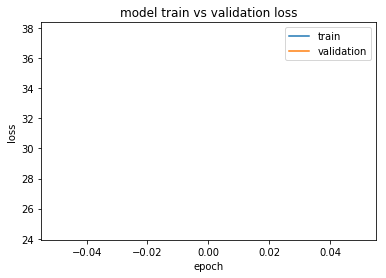

In [38]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [41]:
history=model.fit(x=[TrainingDataIX,decoderInputSummary], 
          y=decoderTargetSummary,
          batch_size=32,
          epochs=1000,initial_epoch=10,
          validation_split=0.2,callbacks=[checkpointer])

Train on 760 samples, validate on 190 samples
Epoch 11/1000
760/760 [==============================] - 129s - loss: 4.8668 - acc: 0.5199 - val_loss: 4.9409 - val_acc: 0.5284
Epoch 12/1000
760/760 [==============================] - 127s - loss: 4.8505 - acc: 0.5263 - val_loss: 4.9928 - val_acc: 0.5284
Epoch 13/1000
760/760 [==============================] - 127s - loss: 4.8399 - acc: 0.5337 - val_loss: 5.0013 - val_acc: 0.5326
Epoch 14/1000
760/760 [==============================] - 135s - loss: 4.8112 - acc: 0.5391 - val_loss: 4.9941 - val_acc: 0.5313
Epoch 15/1000
760/760 [==============================] - 135s - loss: 4.8033 - acc: 0.5404 - val_loss: 4.9686 - val_acc: 0.5343
Epoch 16/1000
760/760 [==============================] - 130s - loss: 4.7858 - acc: 0.5418 - val_loss: 4.9955 - val_acc: 0.5358
Epoch 17/1000
760/760 [==============================] - 129s - loss: 4.8146 - acc: 0.5453 - val_loss: 5.0286 - val_acc: 0.5345
Epoch 18/1000
760/760 [==============================] - 1

KeyboardInterrupt: 

In [42]:
print(history.history['acc'])

[0.28921052664518354, 0.47055921429081965, 0.47368421240856773, 0.47980263452780875, 0.48845394818406357, 0.48957236597412512, 0.49608553365657204, 0.49970394655277856, 0.50911184423848199, 0.51878289674457756]


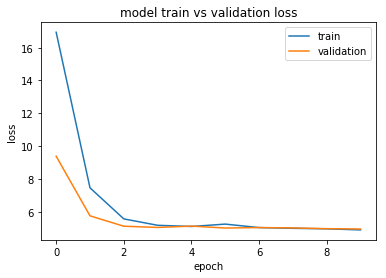

In [43]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# Inferencing

In [39]:
#Encoder Inference
encoder_model_inf=Model(inputs=encoder_input,outputs=encoder_states)

In [40]:
#Decoder Inference
decoder_state_input_h=Input(shape=(300,))
decoder_state_input_c = Input(shape=(300,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]
decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input,initial_state=decoder_input_states)
decoder_states=[decoder_h,decoder_c]
#decoder_inf_out = decoder_dense_rel(decoder_out)
#decoder_inf_final_out=decoder_dense(decoder_inf_out)
#decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,outputs=[decoder_inf_final_out] + decoder_states )
decoder_inf_final_out = decoder_dense(decoder_out)
decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,
                          outputs=[decoder_inf_final_out] + decoder_states )

In [41]:
modiefiedSummaryWord_index['SOS']

5423

In [42]:
int_to_vocab_summaries = {}
for word, value in modiefiedSummaryWord_index.items():
    int_to_vocab_summaries[value] = word

In [43]:
def decode_seq(input_seq):
    # Initial states value is coming from the encoder 
    #We get the encoder states into states_val variable
    states_val = encoder_model_inf.predict(input_seq)#return encoder states
    target_seq = np.zeros((1,1,ModifiedVocabSize))
    print('target_seq shape:->',target_seq.shape)
    target_seq[0, 0, modiefiedSummaryWord_index['SOS']] = 1
    print(target_seq.shape)
    #target_seq=embeddingModifiedSummaries[modiefiedSummaryWord_index['SOS']]
    summarized_sent = ''
    stop_condition = False
    i=1
    while not stop_condition:
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)
        #print(decoder_out)
        max_val_index = np.argmax(decoder_out[0,-1,:])
        sampled_summary_word = int_to_vocab_summaries[max_val_index]
        #print('sampled_summary_word is:->',sampled_summary_word)
        #print()
        summarized_sent += sampled_summary_word+" "
        #print('summarized_sent is:->',summarized_sent)
        #print()
        if ((sampled_summary_word == 'EOS') or (len(summarized_sent) >= maxSummaryLength)) :
            print('terminated')
            stop_condition = True
        
        target_seq = np.zeros((1,1,ModifiedVocabSize))
        target_seq[0, 0, max_val_index]=1
        
        states_val = [decoder_h, decoder_c]
        i=i+1
        
    return summarized_sent

In [44]:
human_summary=[]
for i in range(50):    
    #print('System Generated Summary:',summary)
    temp=[]
    for j in range(len(testPaddedSummary[i])):
        temp.append(int_to_vocab_summaries[testPaddedSummary[i][j]])
    human_summary.append(temp)    
humanSummary=" "        
for i in range(50):
    data=testPaddedReviews[i].reshape(1,200)
    summary=decode_seq(data)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    humanSummary=" "
   

target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  after a string of subpar sequels this bloody actionpacked reboot takes the predator franchise back to its testosteronefueled roots PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  half nelson features powerful performances from ryan gosling and shareeka epps it is a wise unsentimental portrait of lonely people at the crossroads PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  director werner herzog has once again made a compelling tale of man versus nature and christian bale completely immerses himself in the role of figh

terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  despite a few laughs and good intentions the ringer is too predictable to really score the points it aims for PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  faithful to the source material without sacrificing its own cinematic flair justin kurzels macbeth rises on the strength of a mesmerizing michael fassbender performance to join the upper echelon of bigscreen shakespeare adaptations PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  more depth about the legendary outlaw would be welcome but as it is ned kelly is a reasonably entertaining western PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PA

terminated
System Generated Summary: PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  chweneyagaes powerful performance carries this simple yet searing tale of a shantytown teenagers redemption PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  eager to please and stuffed with stars valentines day squanders its promise with a frantic episodic plot and an abundance of romcom cliches PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 


In [45]:
from nltk.translate.bleu_score import sentence_bleu

In [46]:
humanSummary=" "  
scores=[]
for i in range(50):
    testData=testPaddedReviews[i].reshape(1,200)
    summary=decode_seq(testData)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    #calculation of bleu score
    score=sentence_bleu(nltk.word_tokenize(summary),nltk.word_tokenize(humanSummary),weights=(0.5, 0.5, 0, 0))
    print('BlEU SCORE IS:->',score)
    scores.append(score)      
    humanSummary=" "

total=0
for i in scores:
    total+=i
print('AVERAGE BLEU SCORE:->',total/len(scores))   

target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  after a string of subpar sequels this bloody actionpacked reboot takes the predator franchise back to its testosteronefueled roots PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  half nelson features powerful performances from ryan gosling and shareeka epps it is a wise unsentimental portrait of lonely people at the crossroads PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  director werner herzog has once again made a compelling tale of man versus nature and christian bale completel

target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  despite a few laughs and good intentions the ringer is too predictable to really score the points it aims for PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  faithful to the source material without sacrificing its own cinematic flair justin kurzels macbeth rises on the strength of a mesmerizing michael fassbender performance to join the upper echelon of bigscreen shakespeare adaptations PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  more depth about the legendary outlaw would be welcome but as it is ned kelly is a reasonably

terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  this modest cinematic sliceoflife manages to subtly capture many small but resonant and truthful moments of adolescence PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  chweneyagaes powerful performance carries this simple yet searing tale of a shantytown teenagers redemption PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0
target_seq shape:-> (1, 1, 5425)
(1, 1, 5425)
terminated
System Generated Summary: the PAD PAD PAD PAD PAD PAD PAD PAD PAD 
Human Summary  eager to please and stuffed with stars valentines day squanders its promise with a frantic episodic plot and an abundance of romcom cliches PAD PAD PAD PAD PAD PAD P